# **Gold Price Prediction Using LSTM**

## **Introduction**

This project predicts **Gold Futures (GC=F)** prices using an **LSTM (Long Short-Term Memory)** model trained on historical data from **Yahoo Finance (2001–present)**.  
Only the **closing price** (`Close`) is used as the prediction target, while other features (Open, High, Low, Volume) are used for context and exploration.

### **Dataset Overview**
- Source: [Yahoo Finance](https://finance.yahoo.com/quote/GC=F)
- Period: 2001–present
- Features:
  - `Open` – Opening price  
  - `High` – Highest price  
  - `Low` – Lowest price  
  - `Close` – Closing price *(target)*  
  - `Volume` – Trading volume  

The dataset is downloaded automatically using the `yfinance` library and explored using `pandas.describe()` for summary statistics.

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Bidirectional, LayerNormalization, BatchNormalization
from tensorflow.keras.layers import LSTM, Input, Dense, Dropout, Attention, Flatten, Concatenate

In [2]:
ticker = "GC=F"
data = yf.download(ticker, start="2001-01-01", auto_adjust=True)

[*********************100%***********************]  1 of 1 completed


In [3]:
display(data)

Price,Close,High,Low,Open,Volume
Ticker,GC=F,GC=F,GC=F,GC=F,GC=F
Date,,,,,
2001-01-02,268.399994,268.399994,268.399994,268.399994,0
2001-01-03,268.000000,268.000000,268.000000,268.000000,1
2001-01-04,267.299988,267.299988,267.299988,267.299988,1
2001-01-05,268.000000,268.000000,268.000000,268.000000,0
2001-01-08,268.000000,268.000000,268.000000,268.000000,0
...,...,...,...,...,...
2025-11-03,4000.300049,4020.000000,3959.000000,3976.199951,0
2025-11-04,3947.699951,3995.399902,3927.399902,3994.199951,657


In [4]:
print(data.head())

Price            Close        High         Low        Open Volume
Ticker            GC=F        GC=F        GC=F        GC=F   GC=F
Date                                                             
2001-01-02  268.399994  268.399994  268.399994  268.399994      0
2001-01-03  268.000000  268.000000  268.000000  268.000000      1
2001-01-04  267.299988  267.299988  267.299988  267.299988      1
2001-01-05  268.000000  268.000000  268.000000  268.000000      0
2001-01-08  268.000000  268.000000  268.000000  268.000000      0


In [5]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6238 entries, 2001-01-02 to 2025-11-07
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, GC=F)   6238 non-null   float64
 1   (High, GC=F)    6238 non-null   float64
 2   (Low, GC=F)     6238 non-null   float64
 3   (Open, GC=F)    6238 non-null   float64
 4   (Volume, GC=F)  6238 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 292.4 KB
None


In [6]:
print(data.describe())

Price         Close         High          Low         Open         Volume
Ticker         GC=F         GC=F         GC=F         GC=F           GC=F
count   6238.000000  6238.000000  6238.000000  6238.000000    6238.000000
mean    1247.641519  1254.046987  1240.958801  1247.570600    4356.169285
std      691.117871   695.253435   686.537556   690.735291   24378.823929
min      255.100006   256.100006   255.000000   255.000000       0.000000
25%      661.000000   662.725006   659.149979   660.849991      24.000000
50%     1251.549988  1256.599976  1244.950012  1251.699951     117.000000
75%     1677.450012  1689.200012  1665.950012  1676.475006     445.000000
max     4336.399902  4358.000000  4214.600098  4354.700195  386334.000000


## **Data Visualization**

### **Gold Price Trend**
A **line plot** of the `Close` price over time is used to observe long-term trends, such as upward or downward movements and consolidation periods.

- **X-axis:** Date  
- **Y-axis:** Closing price (USD)

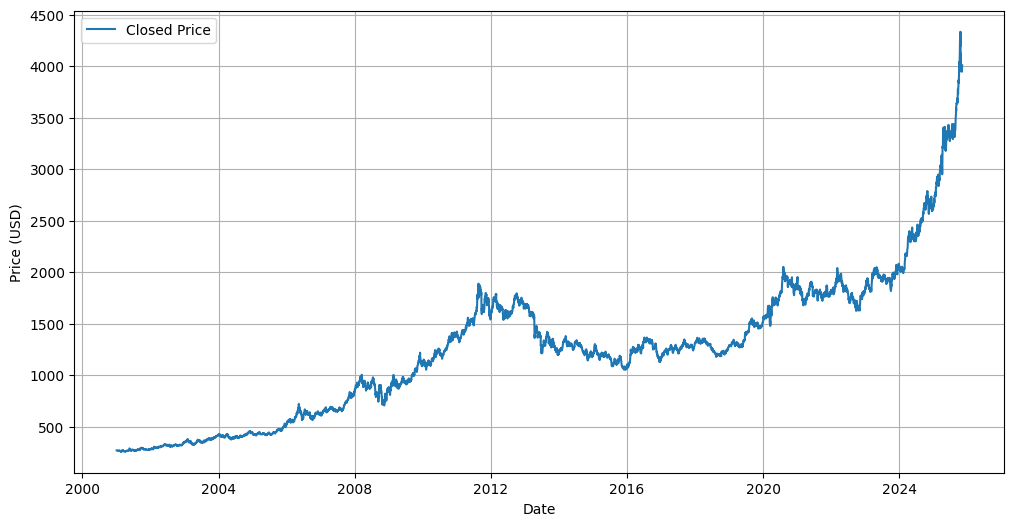

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(data['Close'], label='Closed Price')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

### **Price Distribution**
A **histogram with KDE curve** visualizes the distribution of closing prices to show average tendencies and overall spread.

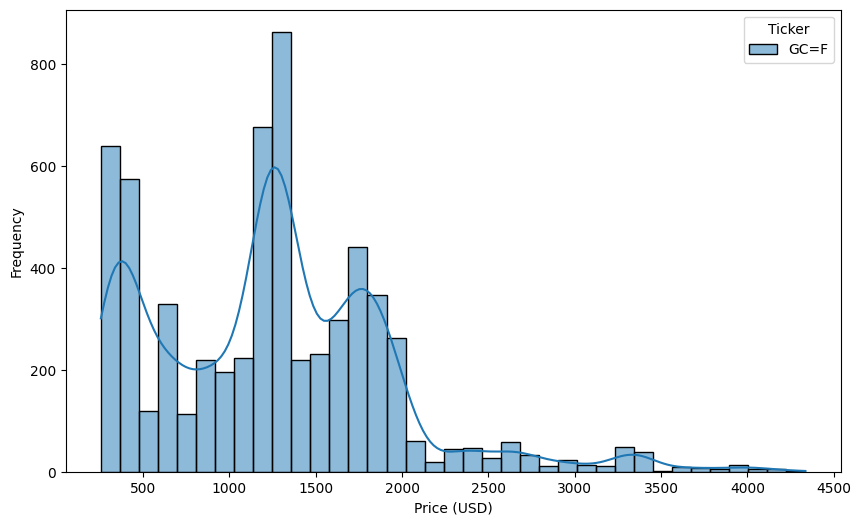

In [8]:
plt.figure(figsize=(10, 6))
sns.histplot(data['Close'], kde=True)
plt.xlabel('Price (USD)')
plt.ylabel('Frequency')
plt.show()


### **Correlation Matrix**
A **heatmap** illustrates correlations among all features (`Open`, `High`, `Low`, `Close`, `Volume`):
- 🔴 Positive correlation → variables move together  
- 🔵 Negative correlation → variables move oppositely  

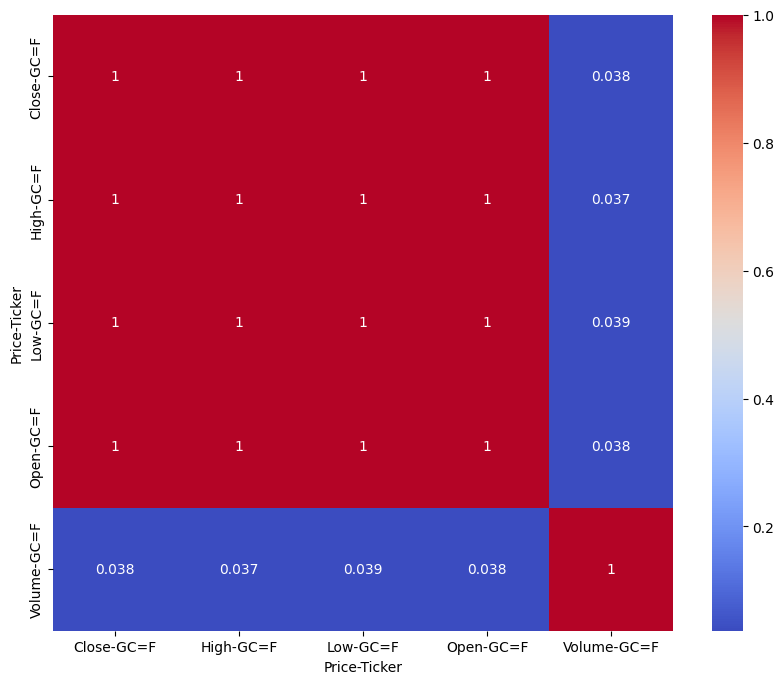

In [9]:
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.show()

In [10]:
print(data.isnull().sum())

Price   Ticker
Close   GC=F      0
High    GC=F      0
Low     GC=F      0
Open    GC=F      0
Volume  GC=F      0
dtype: int64


### **Train dan Val Loss**
A line chart shows the decrease of loss values across epochs for both training and validation datasets — used to monitor learning stability and detect overfitting.

In [11]:
def visualisasi_loss(history, title='Training and Validation Loss'):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()

### **Prediction Results**
The final comparison plot displays:

🟦 Actual gold prices vs. 🟧 Predicted prices
to visually evaluate model accuracy and how well the LSTM follows historical trends.

In [12]:
def visualisasi_hasil_prediksi(train_dates, real_prices, predicted_prices, judul):
    plt.figure(figsize=(12, 6))
    plt.plot(train_dates[:len(real_prices)], real_prices, label='Actual Price')
    plt.plot(train_dates[:len(predicted_prices)], predicted_prices, label='Predicted Price')
    plt.title(judul)
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.show()

## **Pre-Processing**

### Feature Selection
Only the **closing price (`Close`)** is used as the main input feature for prediction.  
Outliers are not removed since extreme values may carry valuable information about price behavior.

### Normalization
Data is scaled to the **[0, 1]** range using `MinMaxScaler` to stabilize training and accelerate model convergence.


### Sequence Generation
To capture temporal patterns, a custom `create_sequences()` function builds sliding-window samples:

- **X:** closing prices over the past 60 days  
- **y:** price at the next day (t + 1)

This transforms the data into a supervised format suitable for LSTM models.

### Train–Test Split
Data is divided chronologically (no shuffling):

- **Train:** 80 %  
- **Test:** 20 %  

This preserves temporal order, crucial for time-series forecasting.

### Date Alignment
- `train_dates` correspond to the time indices of `y_train`  
- `test_dates` represent the subsequent timeline for evaluation and visualization

### Training Parameters
- **Epochs:** 100  
- **Batch size:** 32  
Chosen for stable convergence and balanced computational efficiency.

In [13]:
close_prices = data['Close'].values.reshape(-1, 1)

scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(close_prices)

def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length - 1):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 60
X, y = create_sequences(scaled_prices, seq_length)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print("Shape X_train:", X_train.shape)
print("Shape y_train:", y_train.shape)
print("Shape X_test:", X_test.shape)
print("Shape y_test:", y_test.shape)

Shape X_train: (4941, 60, 1)
Shape y_train: (4941, 1)
Shape X_test: (1236, 60, 1)
Shape y_test: (1236, 1)


In [14]:
train_dates = data.iloc[seq_length: len(y_train) + seq_length, :].index
test_dates = data.iloc[len(y_train) + seq_length:, :].index

In [15]:
epochs = 100
batch_size = 32

### Evaluation Metrics
Model performance is measured using:

| Metric | Description |
|:--|:--|
| **MSE** | Average squared prediction error |
| **RMSE** | Square root of MSE (same unit as USD price) |
| **MAPE** | Mean absolute percentage error for interpretability |

A helper function `mean_absolute_percentage_error()` is implemented to compute MAPE.  
These metrics collectively assess accuracy and generalization on both training and test sets.

In [16]:
import numpy as np
from sklearn.metrics import mean_squared_error

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def evaluasi(real_prices, predicted_prices):
    mse = mean_squared_error(real_prices, predicted_prices)
    rmse = np.sqrt(mse)

    mape = mean_absolute_percentage_error(real_prices, predicted_prices)

    print(f'Evaluasi Model:')
    print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
    print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')


## **Model Architecture**

### **LSTM**

A **Sequential LSTM** network is built with the following layers:

- **LSTM (1):** 50 units, `return_sequences=True`, `input_shape=(X_train.shape[1], 1)`  
- **Dropout (1):** 0.3  
- **LSTM (2):** 50 units, `return_sequences=False`  
- **Dropout (2):** 0.2  
- **Dense (Output):** 1 neuron → predicts the next closing price

Model Compilation
- **Optimizer:** Adam (`learning_rate=0.0005`)  
- **Loss Function:** Mean Squared Error (MSE)  
> The model minimizes MSE, suitable for continuous regression targets.

Early Stopping
Applied to prevent overfitting:
- `monitor='val_loss'` → tracks validation loss  
- `patience=20` → stops if no improvement for 20 epochs  
- `restore_best_weights=True` → reverts to best-performing weights

Training Process
- **Epochs:** 100  
- **Batch Size:** 32  
- **Validation Split:** 0.1 (10% of training data)  
- **Callbacks:** `early_stopping`  
Training progress and loss values are stored in the `history` object for later visualization.

Evaluation & Prediction
- **Training Data:**  
  `model.predict(X_train)` → generates predictions in normalized scale  
  → `scaler.inverse_transform()` converts results back to USD scale  

- **Testing Data:**  
  `model.predict(X_test)` → produces test predictions  
  → also scaled back using `scaler.inverse_transform()`  

Final metrics (RMSE, MAPE) are computed on both training and test results to evaluate performance.

#### **Code**

In [17]:
input_shape = (X_train.shape[1], 1)

model_LSTM = Sequential([
    Input(shape=input_shape),
    LSTM(50, return_sequences=True),
    Dropout(0.3),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

optimizer = Adam(learning_rate=0.0005)
model_LSTM.compile(optimizer=optimizer, loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model_LSTM.summary()

history_LSTM = model_LSTM.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=0
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

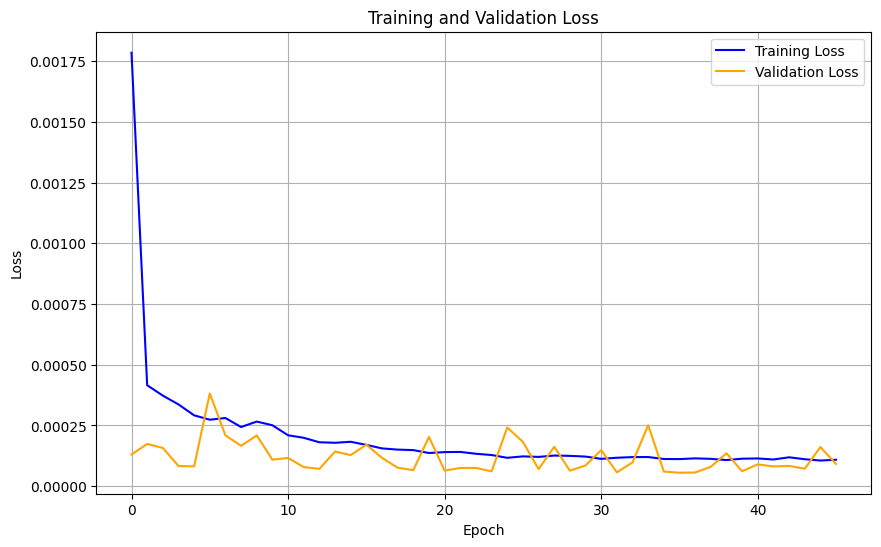

In [18]:
visualisasi_loss(history_LSTM)

In [19]:
predicted_scaled_train_og = model_LSTM.predict(X_train)

predicted_prices_train_og = scaler.inverse_transform(predicted_scaled_train_og)
real_prices_train_og = scaler.inverse_transform(y_train.reshape(-1, 1))

print('Train')
evaluasi(real_prices_train_og, predicted_prices_train_og)


predicted_scaled_og = model_LSTM.predict(X_test)

predicted_prices_test_og = scaler.inverse_transform(predicted_scaled_og)
real_prices_test_og = scaler.inverse_transform(y_test.reshape(-1, 1))

print('Test')
evaluasi(real_prices_test_og, predicted_prices_test_og)

155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step
Train
Evaluasi Model:
Root Mean Squared Error (RMSE): 23.75
Mean Absolute Percentage Error (MAPE): 2.29%
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Test
Evaluasi Model:
Root Mean Squared Error (RMSE): 54.52
Mean Absolute Percentage Error (MAPE): 1.50%


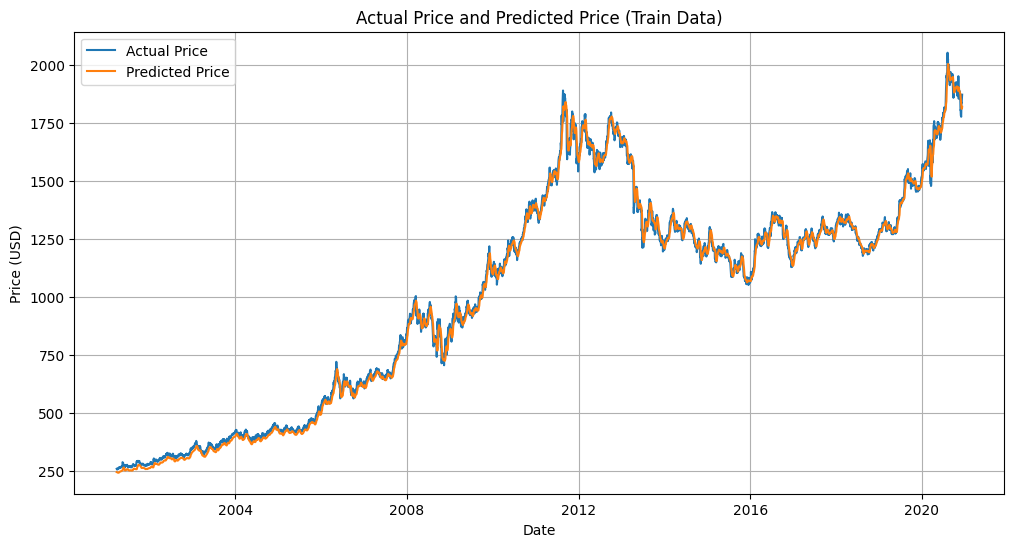

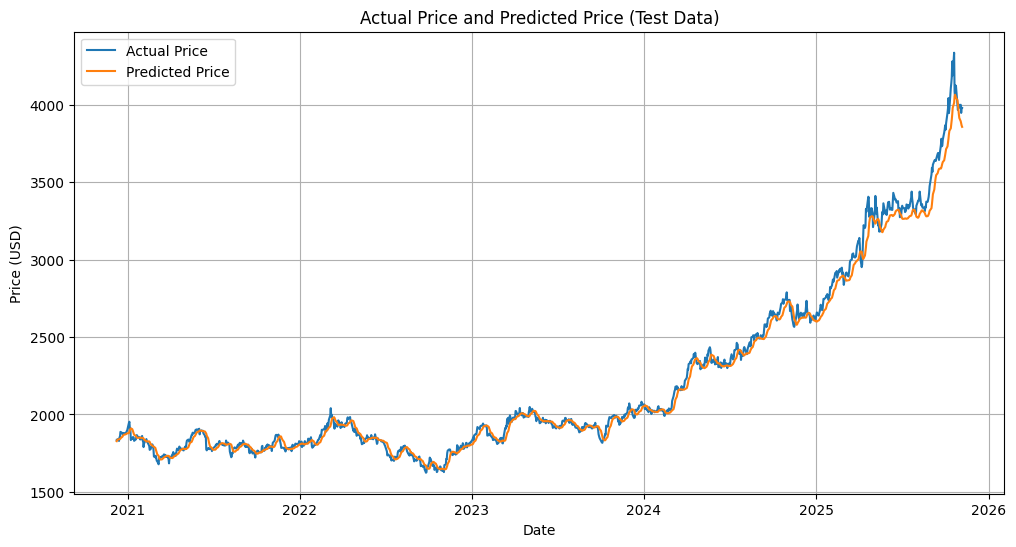

In [20]:
visualisasi_hasil_prediksi(train_dates, real_prices_train_og, predicted_prices_train_og, judul='Actual Price and Predicted Price (Train Data)')
visualisasi_hasil_prediksi(test_dates, real_prices_test_og, predicted_prices_test_og, judul='Actual Price and Predicted Price (Test Data)')

### **Bi-LSTM**

Model Design
The model uses a **Recurrent Neural Network (RNN)** with **Bidirectional LSTM layers**, enabling learning from both past and future time steps.

- **Bidirectional LSTM (1):** 64 units, `return_sequences=True`  
- **Dropout (1):** 0.2  
- **Bidirectional LSTM (2):** 32 units, `return_sequences=False`  
- **Dropout (2):** 0.2  
- **Dense (Output):** 1 neuron → predicts next-day gold price

Model Compilation
- **Optimizer:** Adam (`learning_rate=0.001`)  
- **Loss Function:** Mean Squared Error (MSE) – suited for regression tasks  

Callbacks: EarlyStopping & ReduceLROnPlateau
- **ReduceLROnPlateau:** reduces learning rate by 50% if validation loss stagnates for 3 epochs  
- **EarlyStopping:** stops after 10 epochs without improvement and restores best weights  

Training Configuration
- **Epochs:** 100  
- **Batch size:** 32  
- **Validation split:** 10%  
- **Callbacks:** `[ReduceLROnPlateau, EarlyStopping]`  
Training progress and validation loss are monitored throughout the process.

Evaluation & Prediction
- **Training data:** predictions generated with `model.predict(X_train)` and rescaled using `scaler.inverse_transform()`  
- **Testing data:** predictions also rescaled to USD for performance evaluation  
Accuracy is reported through RMSE and MAPE to assess model effectiveness.


#### **Code**

In [21]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

input_shape = (seq_length, 1)

model_BiLSTM = Sequential([
    Input(shape=input_shape),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(32, return_sequences=False)),
    Dropout(0.2),
    Dense(1)
])

model_BiLSTM.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

history_BiLSTM = model_BiLSTM.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.1,
    callbacks=[reduce_lr, early_stopping],
    verbose=0
)


Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 14: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 17: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 20: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 23: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 26: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
Epoch 28: early stopping
Restoring model weights from the end of the best epoch: 18.


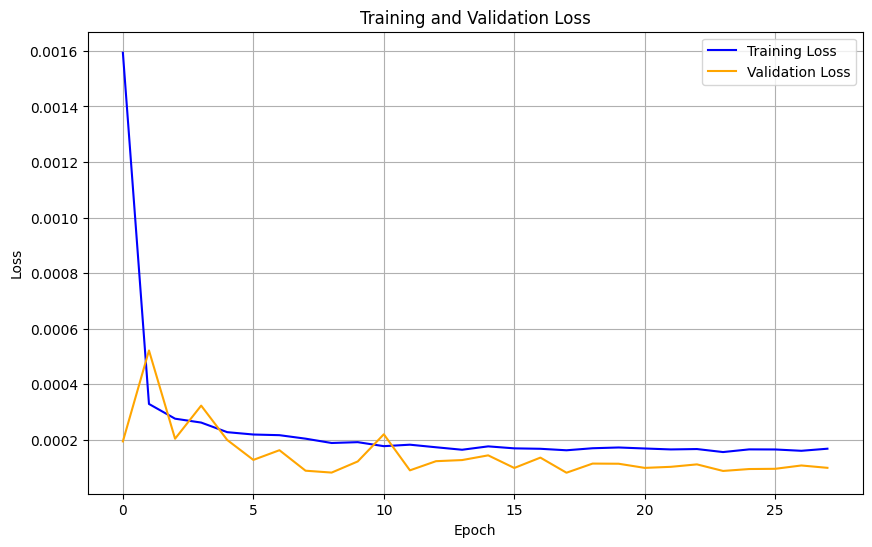

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(history_BiLSTM.history['loss'], label='Training Loss', color='blue')
plt.plot(history_BiLSTM.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
predicted_scaled_train_BiLSTM = model_BiLSTM.predict(X_train)

predicted_prices_train_BiLSTM = scaler.inverse_transform(predicted_scaled_train_BiLSTM)
real_prices_train_BiLSTM = scaler.inverse_transform(y_train.reshape(-1, 1))

print('Train')
evaluasi(real_prices_train_BiLSTM, predicted_prices_train_BiLSTM)


predicted_scaled_BiLSTM = model_BiLSTM.predict(X_test)

predicted_prices_test_BiLSTM = scaler.inverse_transform(predicted_scaled_BiLSTM)
real_prices_test_BiLSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

print('Test')
evaluasi(real_prices_test_BiLSTM, predicted_prices_test_BiLSTM)

155/155 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step
Train
Evaluasi Model:
Root Mean Squared Error (RMSE): 27.07
Mean Absolute Percentage Error (MAPE): 1.98%
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
Test
Evaluasi Model:
Root Mean Squared Error (RMSE): 77.73
Mean Absolute Percentage Error (MAPE): 2.09%


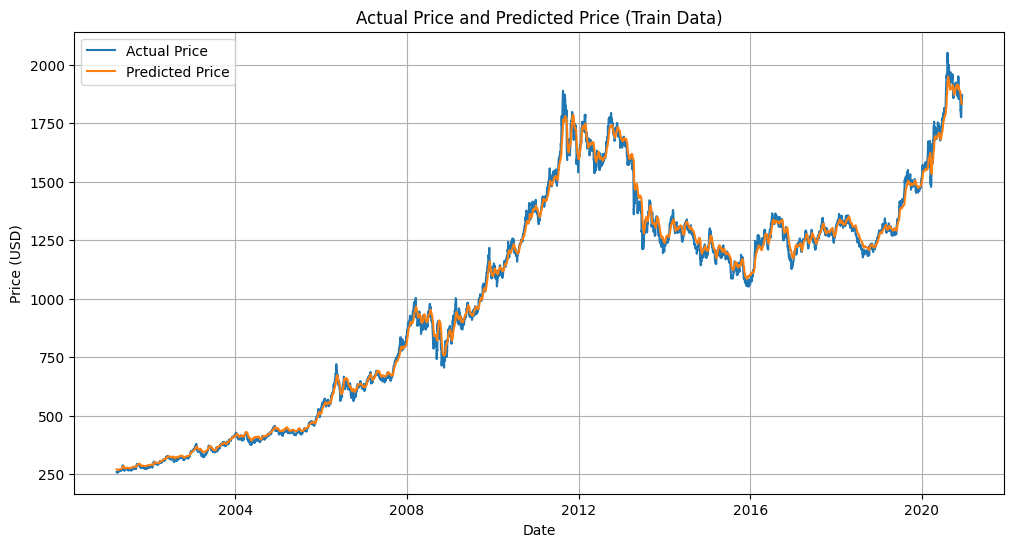

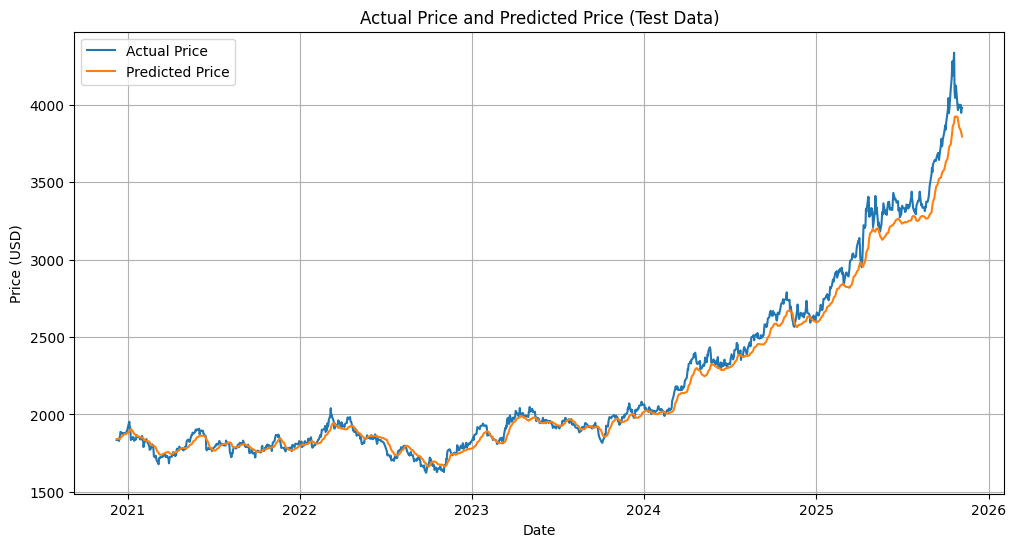

In [24]:
visualisasi_hasil_prediksi(train_dates, real_prices_train_BiLSTM, predicted_prices_train_BiLSTM, judul='Actual Price and Predicted Price (Train Data)')
visualisasi_hasil_prediksi(test_dates, real_prices_test_BiLSTM, predicted_prices_test_BiLSTM, judul='Actual Price and Predicted Price (Test Data)')

### **LSTM witth Attention mechanism**

Model Design
This model combines **LSTM** and **Self-Attention** layers to capture both sequential and temporal dependencies more effectively.

- **Input:** `(X.shape[1], X.shape[2])` – time-step length × feature count  
- **LSTM (1):** 128 units, `return_sequences=True`  
- **Dropout (1):** 0.2  
- **Attention Layer:** self-attention mechanism focusing on the most relevant time steps  
- **LSTM (2):** 64 units, `return_sequences=False`  
- **Dropout (2):** 0.3  
- **Dense:** 20 neurons, ReLU activation  
- **Output:** 1 neuron (linear activation) → predicts next-day gold price  

Model Compilation
- **Loss Function:** Mean Squared Error (MSE) – standard for regression  
- **Optimizer:** Adam – efficient for recurrent architectures  

Callbacks
- **ReduceLROnPlateau:** halves learning rate if validation loss stagnates for 3 epochs  
- **EarlyStopping:** stops after 10 stagnant epochs and restores the best weights  

Training Configuration
- **Epochs:** typically 100  
- **Batch size:** 32  
- **Validation split:** 10 % of training data  
- **Verbose:** 1 (training progress shown)  
Training history is stored in `history_LSTMatt` for later visualization.

Evaluation & Prediction
- **Training data:** predictions generated with `model.predict(X_train)` and rescaled via `scaler.inverse_transform()`  
- **Testing data:** predictions also rescaled to USD for final evaluation  
Model accuracy is assessed using RMSE and MAPE to compare predicted and actual prices.

#### **Code**

In [25]:
input_layer = Input(shape=(X.shape[1], X.shape[2]))
lstm_1 = LSTM(128, return_sequences=True)(input_layer)
drop_1 = Dropout(0.2)(lstm_1)


attn_out = Attention()([drop_1, drop_1])


lstm_2 = LSTM(64, return_sequences=False)(attn_out)
drop_2 = Dropout(0.3)(lstm_2)


dense_1 = Dense(20, activation='relu')(drop_2)
output = Dense(1, activation='linear')(dense_1)

optimizer = Adam(learning_rate=0.0001)


model_LSTMatt = Model(inputs=input_layer, outputs=output)
model_LSTMatt.compile(loss='mean_squared_error', optimizer=optimizer)
model_LSTMatt.summary()

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-6,
    verbose=1
)
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=0
)

history_LSTMatt = model_LSTMatt.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.1,
    callbacks=[reduce_lr, early_stop],
    verbose=0
)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 60, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 60, 128)   │     66,560 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 60, 128)   │          0 │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 60, 128)   │          0 │ dropout_4[0][0],  │
│ (Attention)         │                   │            │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 64)        │     49,408 │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64)        │          0 │ lstm_5[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 20)        │      1,300 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         21 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 117,289 (458.16 KB)

 Trainable params: 117,289 (458.16 KB)

 Non-trainable params: 0 (0.00 B)


Epoch 13: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.


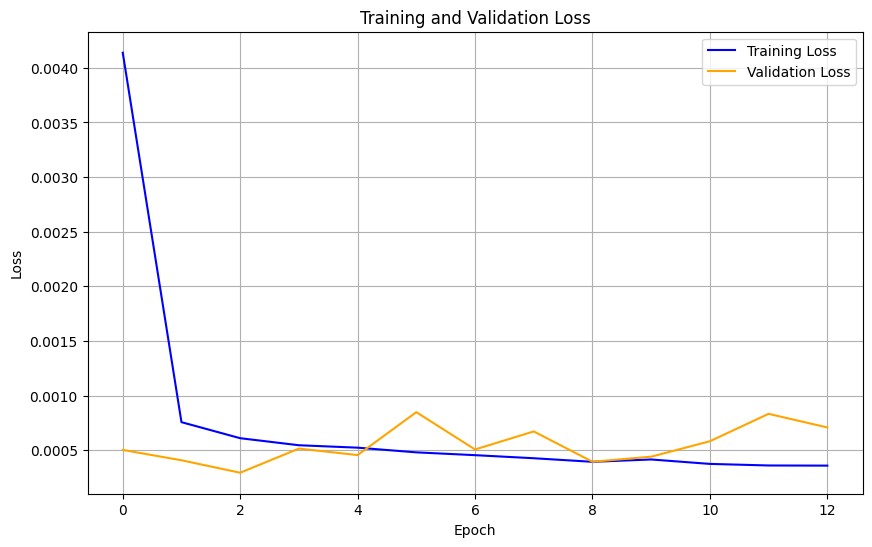

In [26]:
visualisasi_loss(history_LSTMatt)

In [27]:
predicted_scaled_train_att = model_LSTMatt.predict(X_train)

predicted_prices_train_att = scaler.inverse_transform(predicted_scaled_train_att)
real_prices_train_att = scaler.inverse_transform(y_train.reshape(-1, 1))

print('Train')
evaluasi(real_prices_train_att, predicted_prices_train_att)


predicted_scaled_att = model_LSTMatt.predict(X_test)

predicted_prices_test_att = scaler.inverse_transform(predicted_scaled_att)
real_prices_test_att = scaler.inverse_transform(y_test.reshape(-1, 1))

print('Test')
evaluasi(real_prices_test_att, predicted_prices_test_att)

155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step
Train
Evaluasi Model:
Root Mean Squared Error (RMSE): 54.58
Mean Absolute Percentage Error (MAPE): 4.63%
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
Test
Evaluasi Model:
Root Mean Squared Error (RMSE): 98.38
Mean Absolute Percentage Error (MAPE): 3.38%


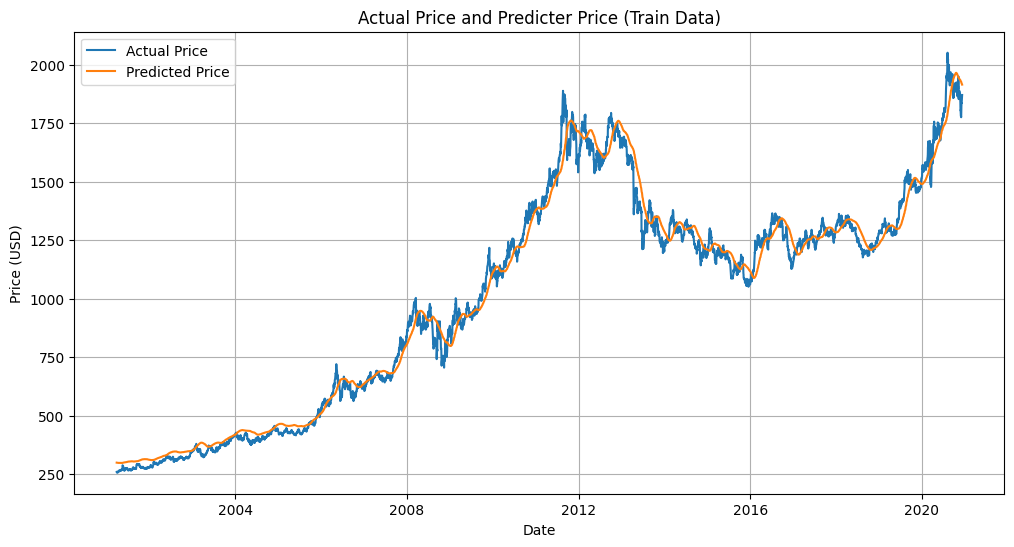

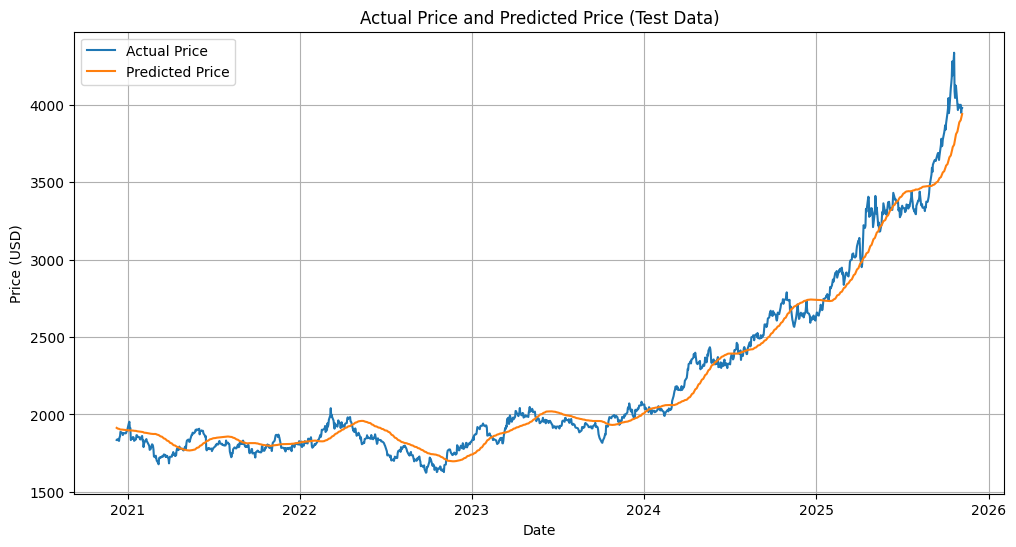

In [28]:
visualisasi_hasil_prediksi(train_dates, real_prices_train_att, predicted_prices_train_att, judul='Actual Price and Predicter Price (Train Data)')
visualisasi_hasil_prediksi(test_dates, real_prices_test_att, predicted_prices_test_att, judul='Actual Price and Predicted Price (Test Data)')

## **All Models Visualization**

In [29]:
models = [model_LSTM, model_BiLSTM, model_LSTMatt]
model_names = ['Vanilla', 'BiDirectional', 'Attention']
histories = [history_LSTM, history_BiLSTM, history_LSTMatt]

results = {}
metrics = {}

for model, name in zip(models, model_names):
    predicted_scaled = model.predict(X_test)
    predicted_scaled_train = model.predict(X_train)

    predicted_prices = scaler.inverse_transform(predicted_scaled)
    real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

    predicted_prices_train = scaler.inverse_transform(predicted_scaled_train)
    real_prices_train = scaler.inverse_transform(y_train.reshape(-1, 1))

    results[name] = predicted_prices

    mse = mean_squared_error(real_prices, predicted_prices)
    mse_train = mean_squared_error(real_prices_train, predicted_prices_train)

    mae = mean_absolute_error(real_prices, predicted_prices)

    rmse_test = np.sqrt(mse)
    rmse_train = np.sqrt(mse_train)

    mape_test = mean_absolute_percentage_error(real_prices, predicted_prices)
    mape_train = mean_absolute_percentage_error(real_prices_train, predicted_prices_train)

    metrics[name] = {
        'RMSE Train': rmse_train,
        'RMSE Test' : rmse_test,
        'MAPE Train': mape_train,
        'MAPE Test' : mape_test
    }

for name in model_names:
    print(f'\nEvaluasi {name}:')
    print(f"RMSE Train: {metrics[name]['RMSE Train']:.2f}")
    print(f"RMSE Test : {metrics[name]['RMSE Test']:.2f}")
    print(f"MAPE Train: {metrics[name]['MAPE Train']:.2f}%")
    print(f"MAPE Test : {metrics[name]['MAPE Test']:.2f}%")

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
155/155 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step

Evaluasi Vanilla:
RMSE Train: 23.75
RMSE Test : 54.52
MAPE Train: 2.29%
MAPE Test : 1.50%

Evaluasi BiDirectional:
RMSE Train: 27.07
RMSE Test : 77.73
MAPE Train: 1.98%
MAPE Test : 2.09%

Evaluasi Attention:
RMSE Train: 54.58
RMSE Test : 98.38
MAPE Train: 4.63%
MAPE Test : 3.38%


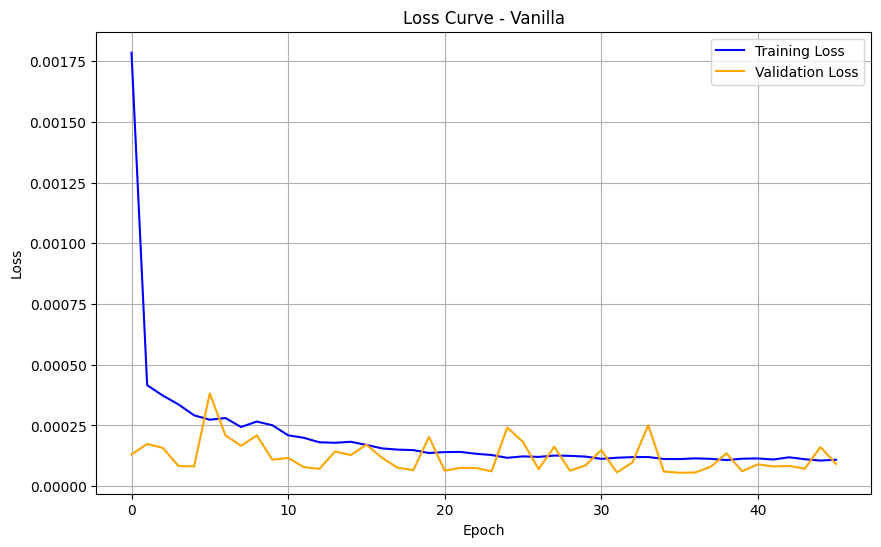

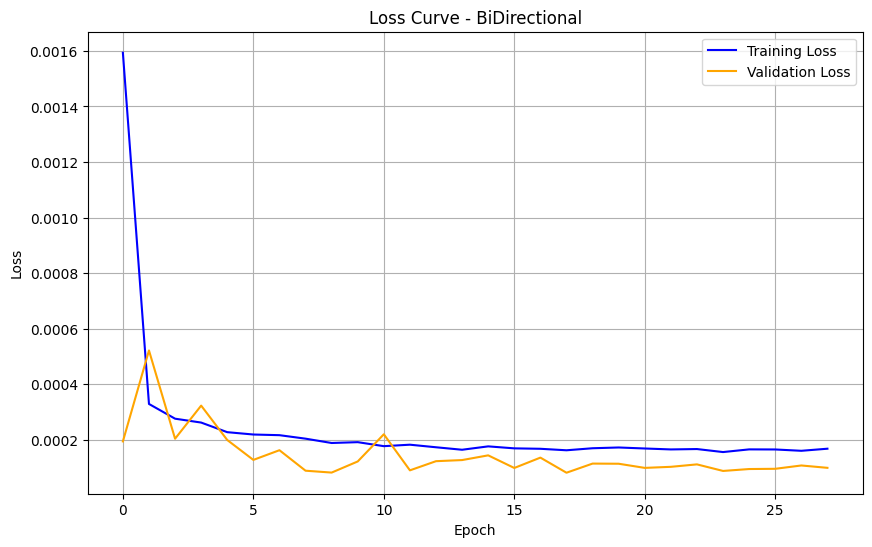

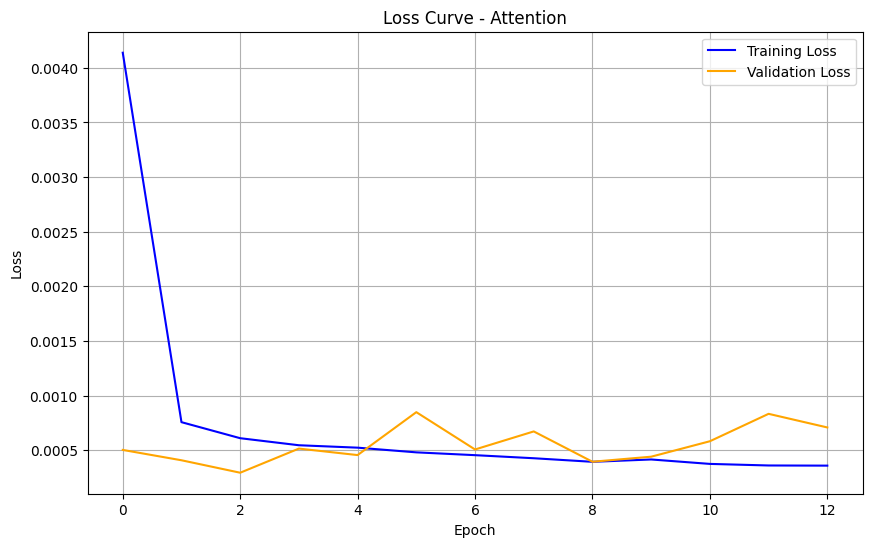

In [30]:
for name, history in zip(model_names, histories):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title(f'Loss Curve - {name}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()

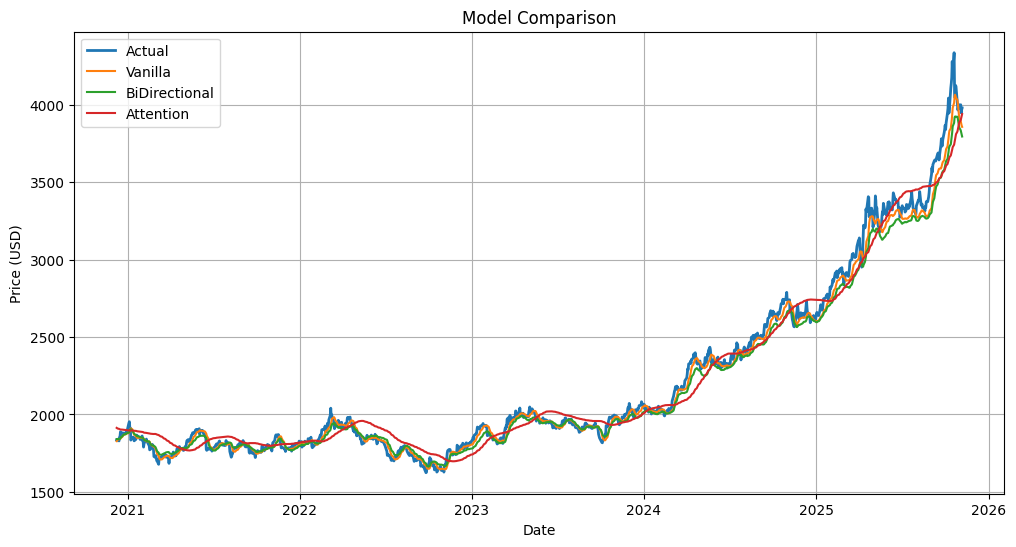

In [31]:
plt.figure(figsize=(12, 6))
plt.plot(test_dates[:len(real_prices)], real_prices, label='Actual', linewidth=2)

for name in model_names:
    plt.plot(test_dates[:len(results[name])], results[name], label=name)

plt.title('Model Comparison')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

### **Analysis**

Based on visualizations and evaluation metrics:

- **Vanilla LSTM** gives the **best overall performance**, achieving the lowest **MAPE (1.50 %)** on test data and demonstrating stable, accurate predictions that closely follow actual trends.  
- **Bidirectional LSTM** captures trend reversals and volatility more sharply, but with slightly higher RMSE and MAPE — indicating greater prediction variance.  
- **LSTM + Attention** performs weakest, often lagging behind sudden price jumps (2023–2025). This aligns with its higher error metrics, suggesting that the current attention configuration may be too simple or insufficiently tuned.

Key Insights
- **Vanilla LSTM** → most accurate and stable; best balance between simplicity and performance.  
- **Bidirectional LSTM** → stronger at identifying turning points but less stable numerically.  
- **LSTM + Attention** → needs deeper tuning or a more advanced attention design to realize benefits.

## **Conclusion**

Among all tested architectures, the **Vanilla LSTM** model demonstrates the **highest accuracy and consistency**, with **MAPE = 1.50 %** and **RMSE = 54.52** on the test set.  
The **Bidirectional LSTM** adds marginal improvement in trend detection but introduces slightly more noise.  
The **Attention-based LSTM**, despite theoretical advantages, underperforms in this experiment — likely requiring architectural refinement or parameter optimization.  

> In conclusion, a well-tuned **Vanilla LSTM** remains the most effective and computationally efficient approach for univariate gold price forecasting within this study.